In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn


In [2]:
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.keys())

data = digits['data']
images = digits['images']
target = digits['target']
target_names = digits['target_names']

print(images.shape) # (1797, 8, 8) 1797 images of 8x8 pixels

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
(1797, 8, 8)


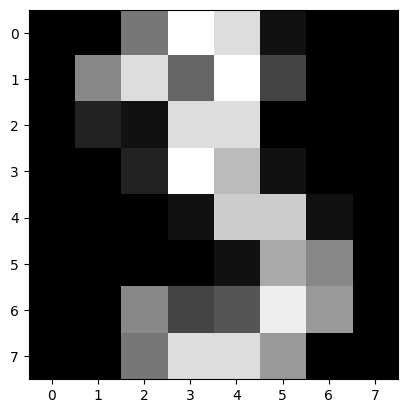

In [3]:
first_three = np.where(target == 3)[0][0]
img = images[first_three]
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.show()

In [4]:
from sklearn import model_selection

threes_and_nines = np.logical_or(target == 3, target == 9)
X_all = data[threes_and_nines]
y_all = target[threes_and_nines]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_all, y_all, test_size=0.4, random_state=0)

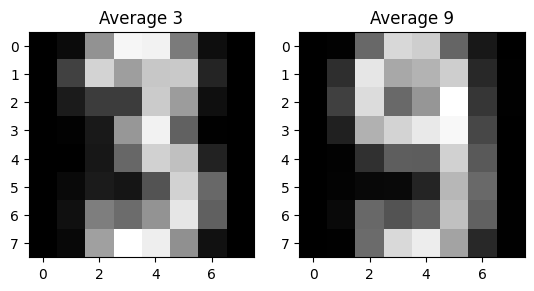

In [5]:
threes = y_train == 3
X_train_three = X_train[threes]
X_train_nine = X_train[~threes]

average_three = np.mean(X_train_three, axis=0)
average_nine = np.mean(X_train_nine, axis=0)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(average_three.reshape(8, 8), cmap='gray', interpolation='nearest')
plt.title('Average 3')
plt.subplot(1, 2, 2)
plt.imshow(average_nine.reshape(8, 8), cmap='gray', interpolation='nearest')
plt.title('Average 9')
plt.show()

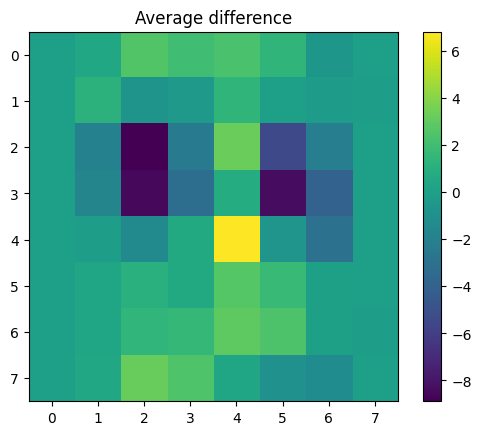

In [6]:
average_diff = average_three - average_nine


plt.figure()
plt.imshow(average_diff.reshape(8, 8), interpolation='nearest')
plt.title('Average difference')
plt.colorbar()
plt.show()

The first feature will be a linear combination of the four most different pixels. 22, 32, 44, 35. This should also give a good indication of whether the image is a 3 or a 9.
The second feature will be a linear combination of some more less important pixels. 25, 24, 72, 64 (written as xy).

In [7]:
def feature2d(X):
    # X has shape (n_samples, n_features) = (n_samples, 64)
    # returns a feature matrix of shape (n_samples, 2)
    X = X / 16.0
    important_pixels = np.zeros(64)
    important_pixels[18], important_pixels[26], important_pixels[29], important_pixels[36] = 1, 1, 1, -1
    feature1 = important_pixels @ X.T
    important_pixels = np.zeros(64)
    important_pixels[20], important_pixels[21], important_pixels[52], important_pixels[58] = 1, -1, 1, 1
    feature2 = important_pixels @ X.T
    return np.array([feature1, feature2]).T

In [8]:
features = feature2d(X_train)

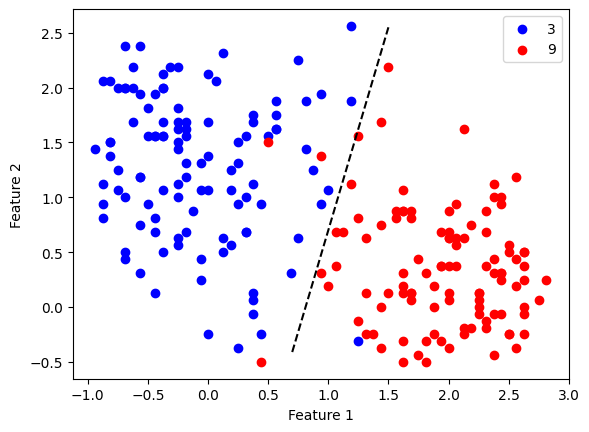

In [9]:
plt.figure()
plt.scatter(features[threes, 0], features[threes, 1], color='b', label='3')
plt.scatter(features[~threes, 0], features[~threes, 1], color='r', label='9')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
X = np.linspace(0.7, 1.5, 100)
Y = X * 3.7 - 3
plt.plot(X, Y, 'k--')
plt.show()

The first feature is very informative, the second feature is less informative but still useful.
Striped line is a possible decision boundary with $\beta = 3.7$ and $b = -3$

In [10]:
def nearest_mean(training_features, training_labels, test_features):
    # training_features has shape (n_samples, 2)
    # training_labels has shape (n_samples,)
    # test_features has shape (n_samples, 2)
    # returns an array of shape (n_samples,) with predicted labels
    threes = training_features[training_labels == 3]
    nines = training_features[training_labels == 9]
    threes_mean = np.mean(threes, axis=0)
    nines_mean = np.mean(nines, axis=0)
    distance_to_threes = np.linalg.norm(test_features - threes_mean, axis=1)
    distance_to_nines = np.linalg.norm(test_features - nines_mean, axis=1)
    return np.where(distance_to_threes < distance_to_nines, 1, -1)

def decision_boundary(test_features):
    beta = 3.7
    b = -3
    y = beta * test_features[:, 0] + b - test_features[:, 1]
    return -np.sign(y) # flip sign to match the sign of the labels

In [11]:
predicted_labels1 = nearest_mean(feature2d(X_train), y_train, feature2d(X_test))
predicted_labels2 = decision_boundary(feature2d(X_test))
correct_labels = np.where(y_test == 3, 1, -1)

accuracy1 = np.mean(predicted_labels1 == correct_labels)
accuracy2 = np.mean(predicted_labels2 == correct_labels)
amount1 = np.sum(predicted_labels1 == correct_labels)
amount2 = np.sum(predicted_labels2 == correct_labels)
print(amount1, amount2)
print(accuracy1, accuracy2)

142 144
0.9726027397260274 0.9863013698630136


Both custom features have good performance, the custom decision boundary is a bit better.

C:\Users\add-iv\AppData\Local\Temp\ipykernel_18680\3879256828.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax[0].plot(1.94, 0.35, 'ko', label='Mean 1', color='b', markersize=10)
C:\Users\add-iv\AppData\Local\Temp\ipykernel_18680\3879256828.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax[0].plot(-0.094, 1.27, 'ko', label='Mean 2', color='r', markersize=10)


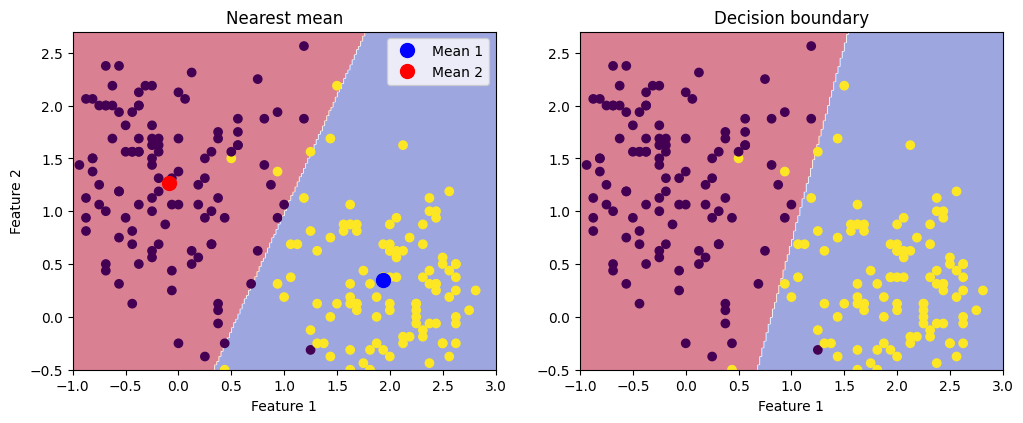

In [12]:
dimension_1 = np.linspace(-1, 3, 200)
dimension_2 = np.linspace(-0.5, 2.7, 200)
D1, D2 = np.meshgrid(dimension_1, dimension_2)
features = np.array([D1.flatten(), D2.flatten()]).T
predicted_labels1 = nearest_mean(feature2d(X_train), y_train, features).reshape(200, 200)
predicted_labels2 = decision_boundary(features).reshape(200, 200)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(predicted_labels1, extent=(-1, 3, -0.5, 2.7), origin='lower', cmap='coolwarm', alpha=0.5)
ax[0].scatter(feature2d(X_train)[:, 0], feature2d(X_train)[:, 1], c=y_train)
ax[0].plot(1.94, 0.35, 'ko', label='Mean 1', color='b', markersize=10)
ax[0].plot(-0.094, 1.27, 'ko', label='Mean 2', color='r', markersize=10)
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')
ax[0].set_title('Nearest mean')
ax[0].legend()
ax[1].imshow(predicted_labels2, extent=(-1, 3, -0.5, 2.7), origin='lower', cmap='coolwarm', alpha=0.5)
ax[1].scatter(feature2d(X_train)[:, 0], feature2d(X_train)[:, 1], c=y_train)
ax[1].set_xlabel('Feature 1')
ax[1].set_title('Decision boundary')

plt.show()



both decision boundaries are similar, but the custom one is a bit better.

Testing with custom 3 image.

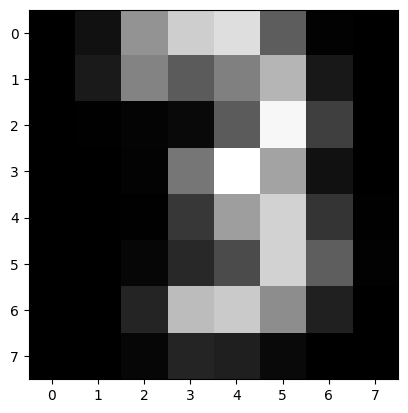

In [23]:
import matplotlib.image as mpimg
img = mpimg.imread('3.png')
img = 1 - img[:, :, 0]
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.show()

In [27]:
img = img.flatten()
img = img.reshape(1, -1)
is_three_decision_boundary = decision_boundary(feature2d(img))[0] == 1
is_three_nearest_mean = nearest_mean(feature2d(X_train), y_train, feature2d(img))[0] == 1
print(is_three_decision_boundary, is_three_nearest_mean)

True True
